In [34]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


True


In [2]:
%load_ext autoreload
%autoreload 2

In [30]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets
from torchvision.utils import make_grid


from torch.utils.tensorboard import SummaryWriter

from models import ConvVAE
from utils import count_model_params
from train import train_model, vae_loss_function

In [4]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

In [5]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if not os.path.exists("imgs/ConvVAE"):
    os.makedirs("imgs/ConvVAE")

In [12]:
# Downloading and Loading Dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Downsaple to 64x64
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='./data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='./data/test', transform=transform)

In [13]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=B_SIZE, 
        shuffle=True,
        num_workers=2
) 
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, 
        batch_size=B_SIZE,
        shuffle=False,
        num_workers=2
)

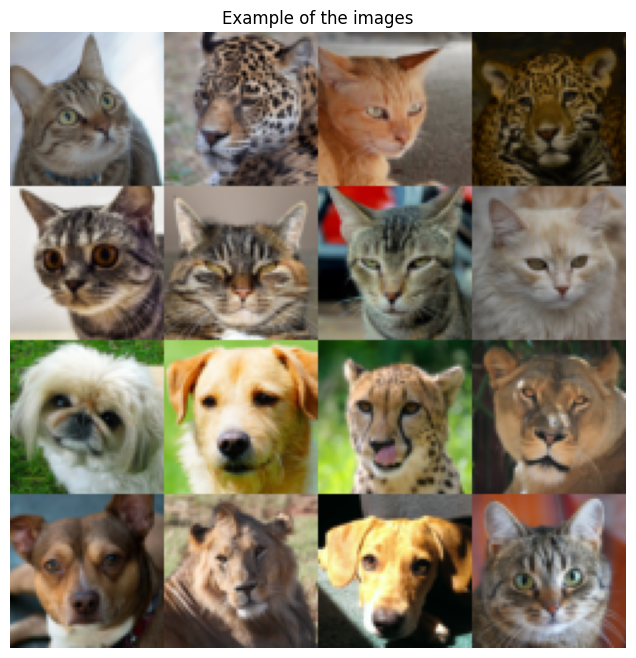

In [19]:
images, labels = next(iter(train_loader))

grid_img = make_grid(images[:16], nrow=4, padding=0, normalize=True)

np_img = grid_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(8, 8))
plt.imshow(np_img)
plt.axis("off")
plt.title("Example of the images")
plt.show()

In [35]:
model = ConvVAE()
model.to(device)

ConvVAE(
  (activation): ReLU()
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=8192, out_features=32, bias=True)
  (fc_sigma): Linear(in_features=8192, out_features=32, bias=True)
  (decoder_fc): Linear(in_features=32, out_features=8192, bias=True)
  (decoder_deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [36]:
count_model_params(model)

Learnable parameters: 1,125,763
Total parameters: 1,125,763


(1125763, 1125763)

In [37]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "ConvVAE")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

savepath = "imgs/ConvVAE"

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

In [41]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10, savepath=savepath,
        writer=writer, device=device
    )

    Train loss: 0.05315
    Valid loss: 0.06079
       Valid loss recons: 0.06078
       Valid loss KL-D:   0.01101
    Train loss: 0.03872
    Valid loss: 0.03911
       Valid loss recons: 0.03301
       Valid loss KL-D:   6.09698
    Train loss: 0.03725
    Valid loss: 0.03714
       Valid loss recons: 0.02999
       Valid loss KL-D:   7.1516
    Train loss: 0.03655
    Valid loss: 0.03651
       Valid loss recons: 0.02876
       Valid loss KL-D:   7.75282
    Train loss: 0.03621
    Valid loss: 0.03608
       Valid loss recons: 0.02801
       Valid loss KL-D:   8.06983
    Train loss: 0.03615
    Valid loss: 0.03577
       Valid loss recons: 0.02797
       Valid loss KL-D:   7.80804
Training completed
